In [ ]:
# zwykły rounding
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

def get_qparams(tensor, qmin, qmax, per_channel=False, channel_axis=0):
    if per_channel:
        dims = list(range(tensor.ndim))
        dims.remove(channel_axis)
        min_vals = tensor.amin(dim=dims, keepdim=True)
        max_vals = tensor.amax(dim=dims, keepdim=True)
    else:
        min_vals = tensor.min()
        max_vals = tensor.max()
    scale = (max_vals - min_vals) / float(qmax - qmin)
    scale = torch.clamp(scale, min=1e-8)
    zero_point = min(max(int(torch.round(qmin - min_vals / scale)), qmin), qmax)
    return scale, zero_point

def quantize_tensor(tensor, scale, zero_point, qmin, qmax):
    q = torch.round(tensor / scale + zero_point)
    q = torch.clamp(q, qmin, qmax)
    return scale * (q - zero_point)

def quantize_layer_weights(layer, bitwidth=8, per_channel=False):
    signed = True
    qmin, qmax = (-(2**(bitwidth - 1)), 2**(bitwidth - 1) - 1) if signed else (0, 2**bitwidth - 1)

    weight = layer.weight.data

    if isinstance(layer, nn.Conv2d):
        channel_axis = 0  # out_channels
        scale_w, zp_w = get_qparams(weight, qmin, qmax, per_channel=per_channel, channel_axis=channel_axis)
    elif isinstance(layer, nn.Linear):
        # dla Linear per_channel = False, lub można użyć axis=0 (out_features)
        scale_w, zp_w = get_qparams(weight, qmin, qmax, per_channel=False)  # można też dodać parametr channel_axis=0
    else:
        raise NotImplementedError("Only Conv2d and Linear layers are supported.")

    weight_q = quantize_tensor(weight, scale_w, zp_w, qmin, qmax)
    layer.weight.data.copy_(weight_q)



# --- Wrapper ---
class StaticRoundQuantWrapper:
    def __init__(self, model):
        self.model = copy.deepcopy(model)
        self.model.eval()

    @staticmethod
    def quantize_layer_weights_recursive(module, bitwidth=8, per_channel=False):
        """
        Recursively quantize weights of all Conv2d and Linear layers in the given module.
        """
        for child_name, child_module in module.named_children():
            if isinstance(child_module, (nn.Conv2d, nn.Linear)):
                quantize_layer_weights(child_module, bitwidth, per_channel)
            else:
                # Recurse into submodules (e.g., nn.Sequential, BasicBlock, etc.)
                StaticRoundQuantWrapper.quantize_layer_weights_recursive(child_module, bitwidth, per_channel)

    def quantize_activations(self, sample_input, bitwidth=8):
        qmin, qmax = 0, 2**bitwidth - 1
        activation_stats = {}

        def capture_activations(name):
            def hook_fn(module, input, output):
                activation_stats[name] = output.detach()
            return hook_fn

        hooks = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                hooks.append(module.register_forward_hook(capture_activations(name)))

        with torch.no_grad():
            _ = self.model(sample_input)

        for hook in hooks:
            hook.remove()

        for name, module in list(self.model.named_modules()):
            if name in activation_stats:
                activation = activation_stats[name]
                scale, zp = get_qparams(activation, qmin, qmax)

                class QuantizedReLU(nn.Module):
                    def __init__(self, scale, zp, qmin, qmax):
                        super().__init__()
                        self.scale = scale
                        self.zp = zp
                        self.qmin = qmin
                        self.qmax = qmax

                    def forward(self, x):
                        x = F.relu(x)
                        return quantize_tensor(x, self.scale, self.zp, self.qmin, self.qmax)

                parent = self.model
                modules = name.split('.')
                for m in modules[:-1]:
                    parent = getattr(parent, m)
                setattr(parent, modules[-1], QuantizedReLU(scale, zp, qmin, qmax))

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"[Quant] Quantized model saved to: {path}")

In [36]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision.models import resnet18
import pathlib
from anvil.cifar_small_resnet import ResNet9

# --- Ustawienia ---
BITWIDTH = 4
SUBSET_SIZE = 2048
BATCH_SIZE = 64
base_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/models/")
MODEL_PATH = base_path.joinpath("cifar_model3.pth")
SAVE_PATH = base_path.joinpath("cifar_model_rounded_4bits.pth")

# --- Urządzenie ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet9(3, 10)
# --- Przygotowanie modelu (zgodnie z treningiem) ---
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

# --- Przygotowanie zbioru walidacyjnego (bez normalizacji) ---
transform = transforms.ToTensor()
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

# --- Pobierz reprezentatywny batch jako sample_input ---
sample_input, _ = next(iter(testloader))
sample_input = sample_input.to(device)

In [37]:
def print_unique_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            unique_vals = torch.unique(module.weight.data)
            print(f"{name:30s} | Unique weights: {len(unique_vals)}")

In [38]:
print_unique_weights(model)

conv1.0                        | Unique weights: 1728
conv2.0                        | Unique weights: 73662
res1.0.0                       | Unique weights: 147255
res1.1.0                       | Unique weights: 147235
conv3.0                        | Unique weights: 294106
conv4.0                        | Unique weights: 1167938
res2.0.0                       | Unique weights: 2315580
res2.1.0                       | Unique weights: 2315861
classifier.3                   | Unique weights: 5120


In [39]:
qmin = -127
qmax = 126
scale, zp = get_qparams(model.conv1[0].weight, qmin, qmax, per_channel=False)
scale, zp = scale.cpu().detach(), zp

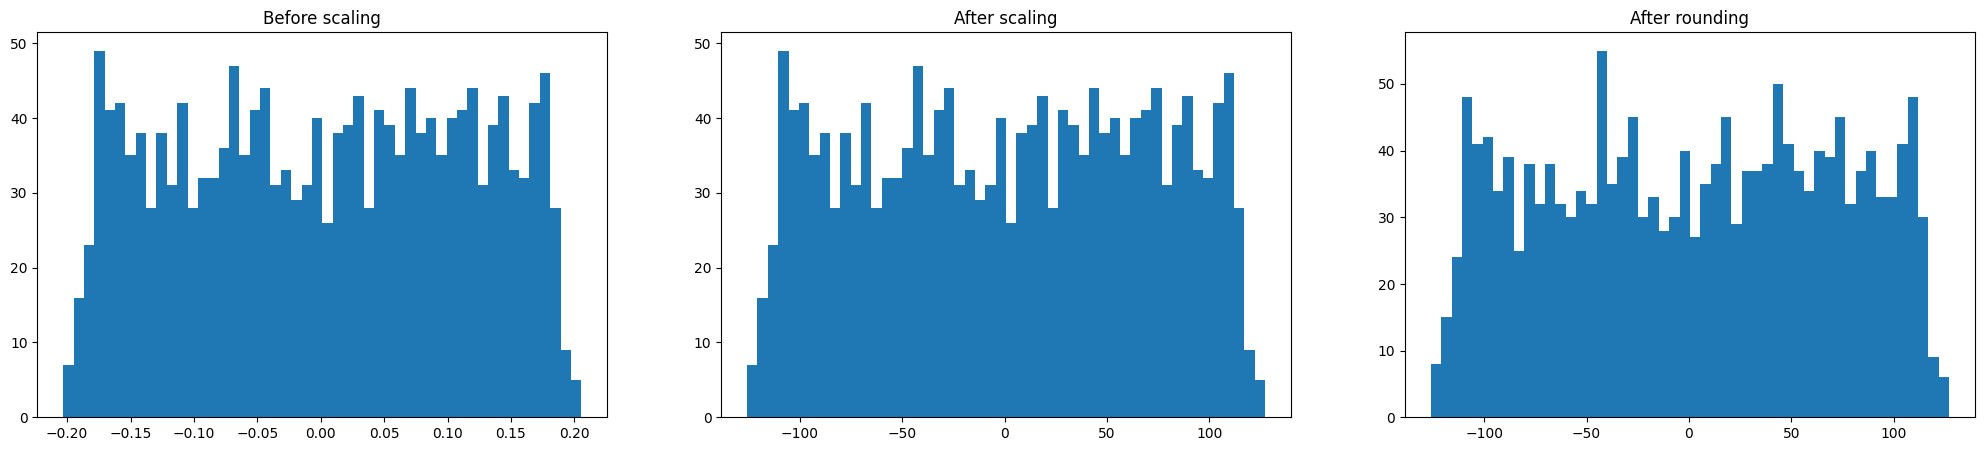

After scaling -- min: -125.76507568359375, max: 127.23489379882812
After applying zp -- min: -126.76507568359375, max: 126.23489379882812


In [40]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize = (25, 5))

raveled_weights = torch.ravel(model.conv1[0].weight).detach().cpu()

axes[0].hist(raveled_weights, bins=50)
axes[0].set_title("Before scaling")

scaled_weights = raveled_weights/scale

axes[1].hist(scaled_weights, bins=50)
axes[1].set_title("After scaling")

shifted_weights = scaled_weights + zp
rounded_weights = torch.round(scaled_weights)

axes[2].hist(rounded_weights, bins=50)
axes[2].set_title("After rounding")

plt.show()

print(f"After scaling -- min: {scaled_weights.min()}, max: {scaled_weights.max()}")
print(f"After applying zp -- min: {shifted_weights.min()}, max: {shifted_weights.max()}")

In [41]:
print(f"scaled mean: {scaled_weights.mean()}")
print(f"shifted mean: {shifted_weights.mean()}")

scaled mean: 1.5180329084396362
shifted mean: 0.5180327296257019


In [42]:
raveled_weights

tensor([-0.0504, -0.1492, -0.1209,  ..., -0.0236,  0.0404,  0.1138])

In [43]:

# --- Kwantyzacja ---
quantizer = StaticRoundQuantWrapper(model)
quantizer.quantize_layer_weights_recursive(bitwidth=4)
quantizer.quantize_activations(sample_input, bitwidth=2)

TypeError: StaticRoundQuantWrapper.quantize_layer_weights_recursive() takes from 1 to 3 positional arguments but 4 were given

In [10]:
print_unique_weights(quantizer.model)

conv1 | unique weights values: 4
layer1.0.conv1 | unique weights values: 4
layer1.0.conv2 | unique weights values: 4
layer1.1.conv1 | unique weights values: 4
layer1.1.conv2 | unique weights values: 4
layer2.0.conv1 | unique weights values: 4
layer2.0.conv2 | unique weights values: 4
layer2.0.downsample.0 | unique weights values: 4
layer2.1.conv1 | unique weights values: 4
layer2.1.conv2 | unique weights values: 4
layer3.0.conv1 | unique weights values: 4
layer3.0.conv2 | unique weights values: 4
layer3.0.downsample.0 | unique weights values: 4
layer3.1.conv1 | unique weights values: 4
layer3.1.conv2 | unique weights values: 4
layer4.0.conv1 | unique weights values: 4
layer4.0.conv2 | unique weights values: 4
layer4.0.downsample.0 | unique weights values: 4
layer4.1.conv1 | unique weights values: 4
layer4.1.conv2 | unique weights values: 4
fc | unique weights values: 4


In [11]:
def evaluate_model(model, dataloader, device):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return all_labels, all_preds

In [12]:
y_true, y_pred = evaluate_model(quantizer.model, testloader, device="cuda:0")

In [13]:
from sklearn import metrics

metrics.accuracy_score(y_true, y_pred)

0.1102

In [3]:
from torchvision.models import resnet18
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model jak przy treningu
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load(SAVE_PATH))
model.eval().to(device)

transform = transforms.Compose([
    transforms.ToTensor()
])  # Bez Normalize, bo nie było tego w treningu

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'✅ Accuracy of quantized (rounded) 4 bits: {accuracy:.2f}%')

✅ Accuracy of quantized (rounded) 4 bits: 81.57%


In [4]:

for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Unique weights: {torch.unique(module.weight).shape}")

Unique weights: torch.Size([813])
Unique weights: torch.Size([928])
Unique weights: torch.Size([930])
Unique weights: torch.Size([925])
Unique weights: torch.Size([927])
Unique weights: torch.Size([1861])
Unique weights: torch.Size([1868])
Unique weights: torch.Size([1714])
Unique weights: torch.Size([1881])
Unique weights: torch.Size([1872])
Unique weights: torch.Size([3709])
Unique weights: torch.Size([3740])
Unique weights: torch.Size([3527])
Unique weights: torch.Size([3589])
Unique weights: torch.Size([3684])
Unique weights: torch.Size([5083])
Unique weights: torch.Size([7394])
Unique weights: torch.Size([6710])
Unique weights: torch.Size([2482])
Unique weights: torch.Size([7381])
Unique weights: torch.Size([16])
